In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [5]:
candidate_sentences['sentence'].sample(5)

1488                                                                                                  g. george, sathyan anthikad, priyadarshan,
424                                                                   i is a 2015 indian tamil-language film written and directed by s. shankar.
1022    main examples include: the morning after , shattered , the long kiss goodnight , memento , the bourne film series , and shutter island .
775                                                                              color photography became more common from the mid-20th century.
953                                                                                winsor mccay's little nemo  showcased very detailed drawings.
Name: sentence, dtype: object

In [6]:
# Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [10]:
"""
The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.
However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency
parsers tag only the individual words as subjects or objects.
"""

def get_entities(sent):
    """
    prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. 
    prefix and modifier will hold the text that is associated with the subject or the object.
    """
    ent1 = ent2 = prv_tok_dep = prv_tok_text = prefix = modifier = str()

    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            # A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = modifier = prv_tok_dep = prv_tok_text = str()   

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

get_entities("the film had 200 patents")

['film', '200  patents']

In [11]:
entity_pairs = [get_entities(i) for i in tqdm(candidate_sentences["sentence"])]

100%|██████████| 4318/4318 [00:50<00:00, 85.34it/s] 


In [12]:
# The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences.
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [13]:
def get_relation(sent):
    """
    Our hypothesis is that the predicate is actually the main verb in a sentence.
    For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.
    """
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [14]:
get_relation("John completed the task")

'completed'

In [15]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:49<00:00, 87.30it/s] 


In [16]:
# take a look at the most frequent relations
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
has               31
became            31
become            29
released in       27
included          26
produced          22
called            22
had               20
considered        20
made              20
be                18
been              18
scheduled         17
used              17
stars             16
directed by       16
written by        15
produced by       14
hired             14
wrote             14
set               14
received          13
went              13
introduced in     13
wanted            12
won               11
began in          11
began             11
features          10
gave              10
sold              10
gives              9
used in            9
includes           9
shot in            9
directed           9
reported           9
opened       

In [17]:
# create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [18]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

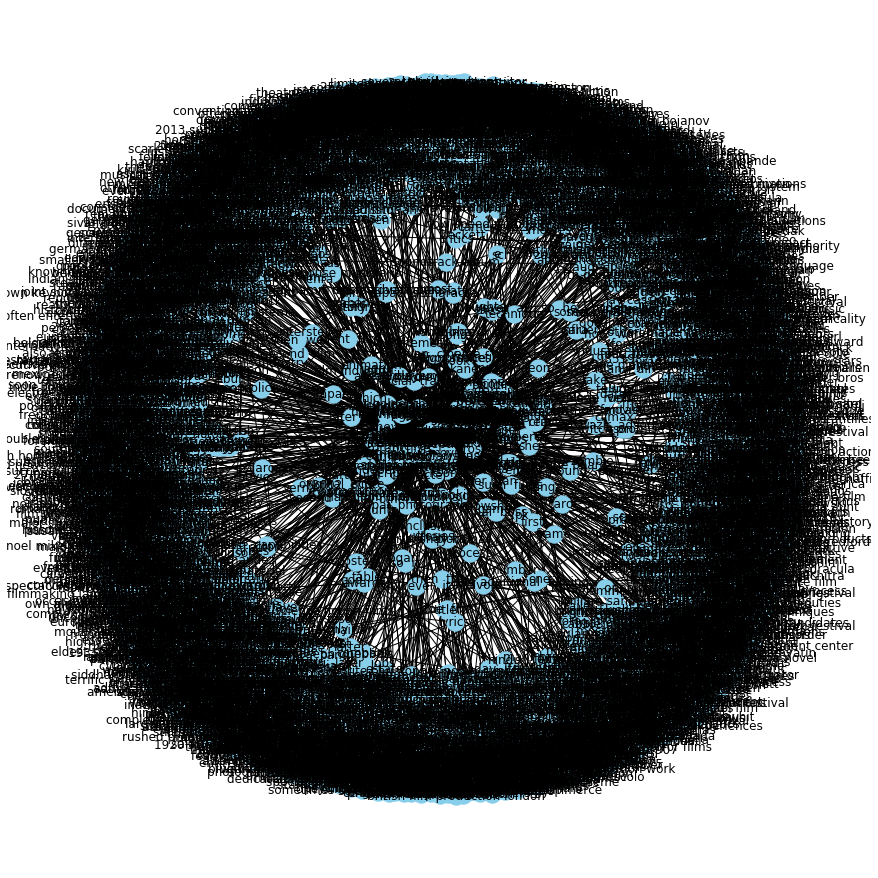

In [19]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

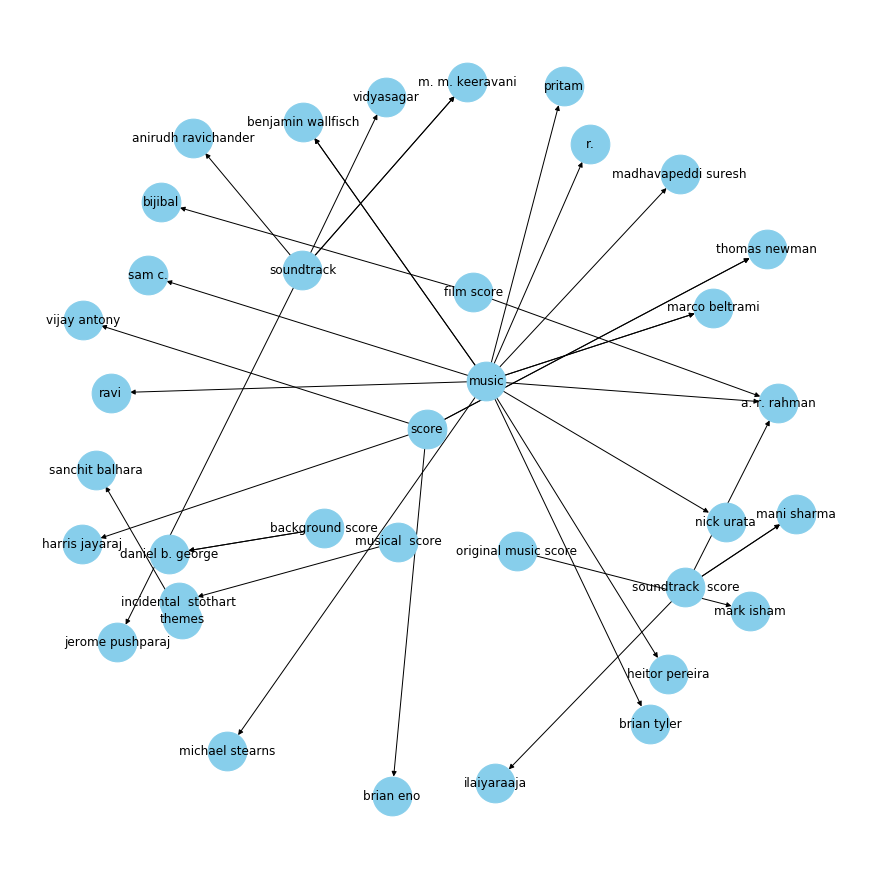

In [20]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

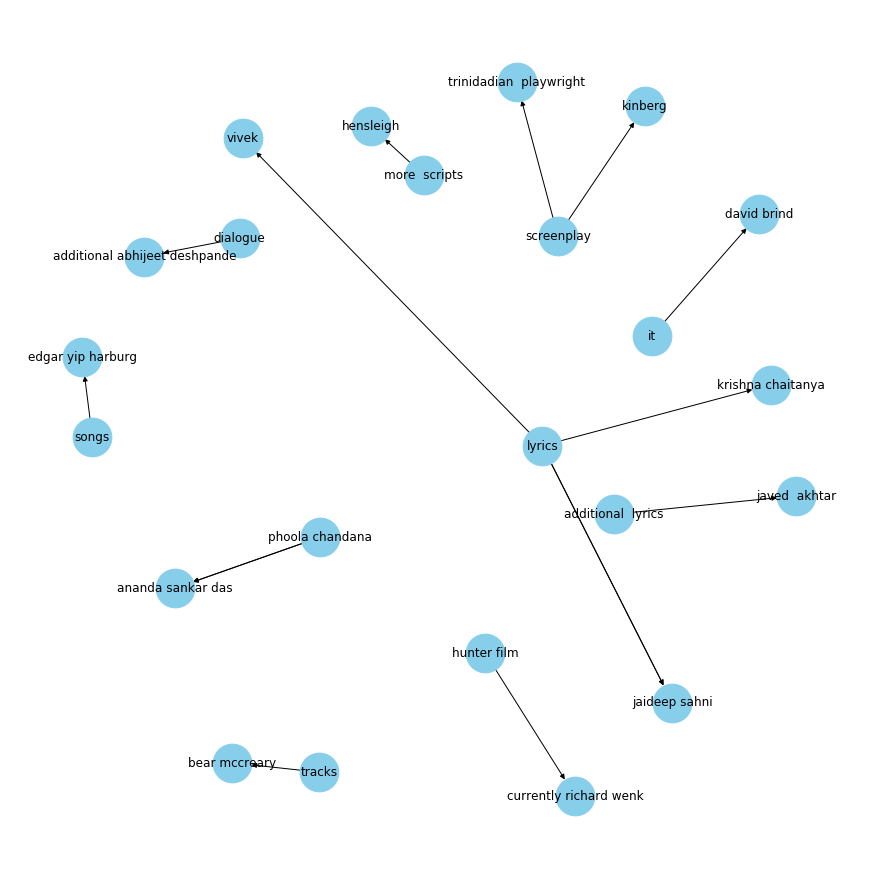

In [21]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

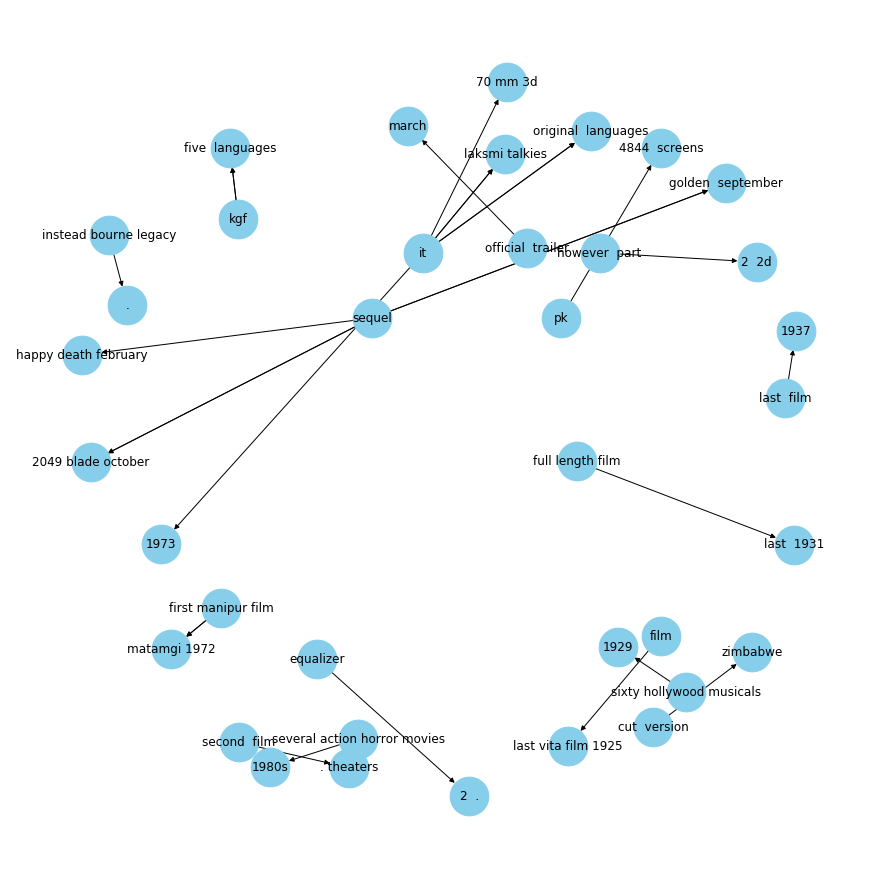

In [22]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()